This codebook is created for the purpose of trying to classify the full MNIST dataset using a hybrid quantum-classical neural network. The codebook is divided into 3 parts: 

0. Python imports
1. Data preparation 
2. Quantum Circuit
3. Variations of main runner 
4. Main Net
5. ~No Results Yet~

The current problem we're facing is
> 1 iteration/per batch/per epoch takes 4 seconds. The whole training process by extension will take weeks to months

In addition to the problems already stated in [HybridRandom](./HybridRandom.ipynb) there are several problems with Qiskit Itself. There are a few Variants of which ive marked below, the issue tracking is [here](https://github.com/Qiskit/qiskit-aer/issues/1765).

In [75]:
import time as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import qiskit
from qiskit.visualization import *
from qiskit.circuit.library import EfficientSU2
import qiskit.circuit as Q
from qiskit.providers.aer import AerSimulator
from qiskit_aer import QasmSimulator

import torch
from torch import cat, no_grad, manual_seed
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import (
 Module, CrossEntropyLoss,
 Conv2d, MaxPool2d,
 Linear, Dropout2d, Flatten, ReLU,
 Sequential, Parameter,
)
import torch.nn.functional as F

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

from utils import gtt, make_filt

In [76]:
dtype = torch.float32
device = torch.device("mps")
qubits = 4
shots = 512
epochs = 10  # Set number of epochs

print(dtype, device)

torch.float32 mps


In [77]:
filt, digits = make_filt([for i in range(10)])
# filt, digits = make_filt([0,1,3,5,6])

qubits = digits
n_train = 2*digits

print(f'using {qubits} |> @{n_train} points ∈ {filt} for {epochs} epochs')
train_loader, test_loader = gtt(n_train, filt, batch_size=1)

using 10 |> @20 points ∈ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] for 10 epochs


In [78]:
def SU2(prefix):
    return EfficientSU2(2, su2_gates=['ry'], entanglement='linear', reps=1, parameter_prefix=prefix)

# We use QasmSimulator in parallel
executor = ThreadPoolExecutor(max_workers=8)
# backend = AerSimulator().from_backend("automatic")
backend = QasmSimulator(method="automatic")
backend.set_options(
    executor=executor, max_job_size=1, 
    max_parallel_threads=8,max_parallel_experiments=0, 
    max_parallel_shots=0
)
print(f"{backend}: \n{backend.options}")

qasm_simulator: 
Options(shots=1024, method='matrix_product_state', device='CPU', precision='double', executor=<concurrent.futures.thread.ThreadPoolExecutor object at 0x14b7a7750>, max_job_size=1, max_shot_size=None, enable_truncation=True, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=8, max_parallel_experiments=0, max_parallel_shots=0, max_memory_mb=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, accept_distributed_results=None, blocking_qubits=None, blocking_enable=False, memory=None, noise_model=None, seed_simulator=None, statevector_parallel_threshold=14, statevector_sample_measure_opt=10, stabilizer_max_snapshot_probabilities=32, extended_stabilizer_sampling_method='resampled_metropolis', extended_stabilizer_metropolis_mixing_time=5000, extended_stabilizer_approximation_error=0.05, extended_stabilizer_norm_estimation_samples=100, extended_stabilizer_norm_estimation_repetitions=3, extended_stabilizer_parallel_thresho

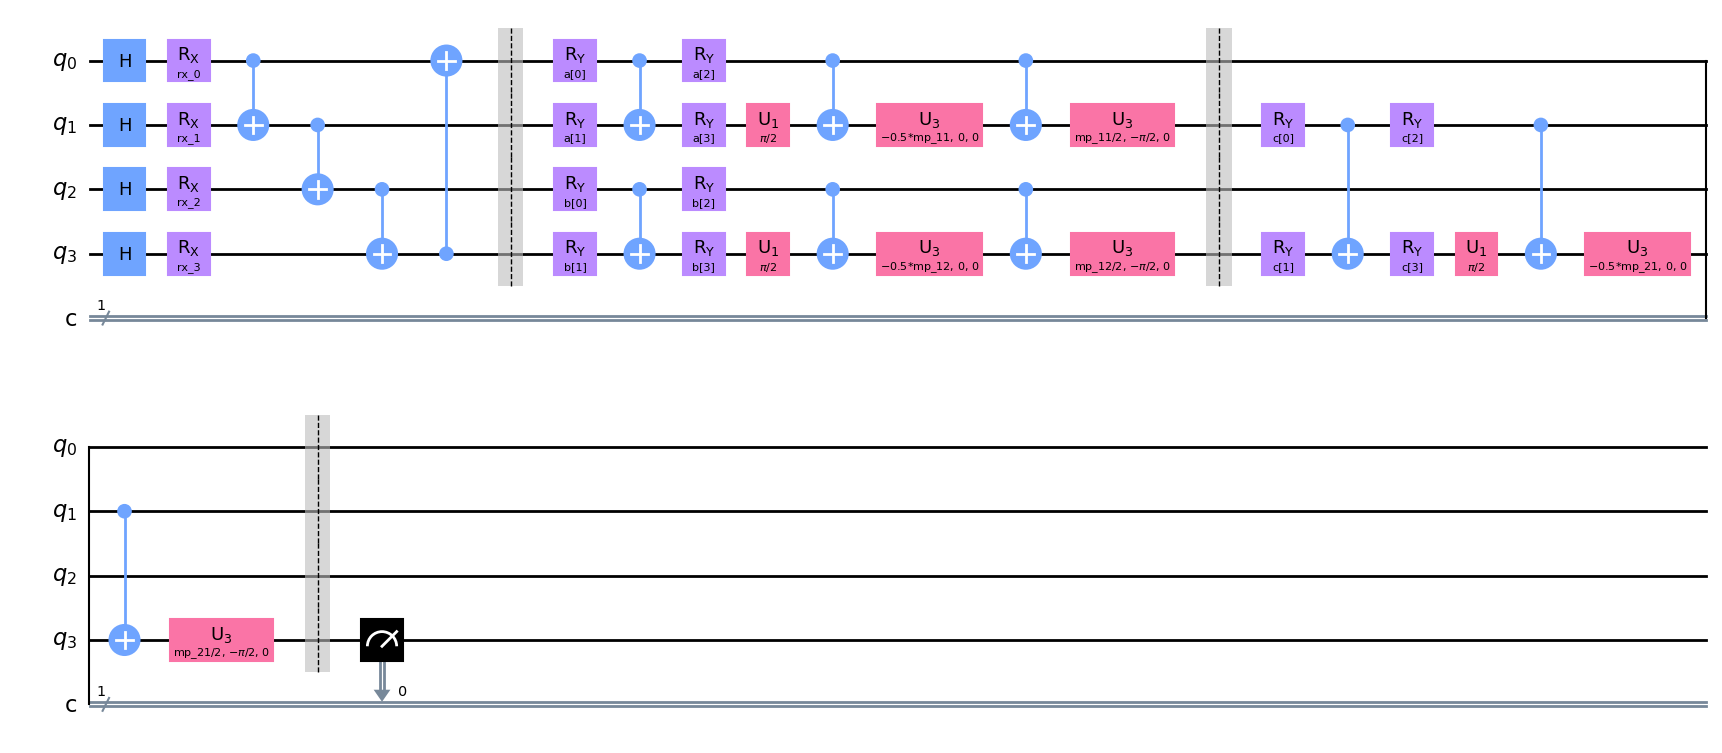

In [27]:
# Main convolutional circuit
# Conv -> MaxPool -> Conv -> MaxPool -> Linear
# Conv =
#  \0> ->  H -> Rx -> U [2 at a time] -> CRX [2 -> 1 reduction i,e maxpool] --> repeat till 1 output -> M
def QConvCircuit():
    qubits = 4
    params = [Q.Parameter(f"rx_{i}") for i in range(0,qubits)]; 
    all_q = [i for i in range(qubits)]; 

    qc = Q.QuantumCircuit(qubits, 1); 

    qc.h(all_q); 
    for i in all_q: qc.rx(params[i], i)
    for i in all_q: qc.cx(i, (i+1)%4)

    qc.barrier()
    qc.compose(SU2('a'), qubits=[0,1], inplace=True)
    qc.compose(SU2('b'), qubits=[2,3], inplace=True)
    qc.crx(Q.Parameter('mp_11'), 0,1)
    qc.crx(Q.Parameter('mp_12'), 2,3)
    qc.barrier()

    qc.compose(SU2('c'), qubits=[1,3], inplace=True)    
    qc.crx(Q.Parameter('mp_21'), 1,3)
    qc.barrier()

    qc.measure(3,0)

    qc = qiskit.compiler.transpile(qc, optimization_level=3, backend=backend)
    return qc

demo = QConvCircuit()
input_names = [i for i in demo.parameters if i.name[0] == "r"]
weight_names = [i for i in demo.parameters if i.name[0] != "r"]

demo.draw('mpl')

### Below are 3 variants of a run function which I tried all of which error out in some way

It is important to note that it is very very desireable to use QasmSimulator directly without any abstractions like `qiskit.execute` since here, 1. we don't need it. 2. It is much much faster since it calls out directly to C++

# Variant 1

In this attempt we pass in all the inputs as a `Dict` of `List`s of variables i.e for 4 diff values of the param `a` we pass in a `Dict` of

```python
{
    'a': [0, 1, 2, 3]
}
```

The error that occurs here is `AttributeError: 'list' object has no attribute 'values'` at `AerBackend._convert_circuit_binds`

In [121]:
def runQConv(circuit, inputs, weights):
    # check if inputs and weights are lists of lists else convert list to list of lists
    if not isinstance(inputs[0], list):
        inputs = [inputs]
    if not isinstance(weights[0], list):
        weights = [weights]
    
    params_list = []
    for i in inputs:
        for w in weights:
            params_list.append({
                **dict(zip(input_names, i)),
                **dict(zip(weight_names, w))
            })

    df = pd.DataFrame(params_list)
    params_list = [df.to_dict('list')]
    
    print(f"We expect {len(params_list)} runs")    
    return backend.run(
        circuit if len(params_list)==1 else [circuit for _ in range(len(params_list))]
        ,parameter_binds=[params_list]).result()

# Variant 2

In this attempt we pass in all the inputs as a List of Dicts as advertised in most documentation

```python
[
    { 'a': 0 },
    { 'a': 1 },
    { 'a': 2 },
    { 'a': 3 }
]
```

The error that occurs here is `TypeError: object of type 'float' has no len()` at `AerBackend._convert_circuit_binds`

In [125]:
def runQConv(circuit, inputs, weights):
    # check if inputs and weights are lists of lists else convert list to list of lists
    if not isinstance(inputs[0], list):
        inputs = [inputs]
    if not isinstance(weights[0], list):
        weights = [weights]
    
    params_list = []
    for i in inputs:
        for w in weights:
            params_list.append({
                **dict(zip(input_names, i)),
                **dict(zip(weight_names, w))
            })

    print(f"We expect {len(params_list)} runs")    
    return backend.run(
        circuit if len(params_list)==1 else [circuit for _ in range(len(params_list))]
        ,parameter_binds=params_list).result()

# Variant 3

In this attempt we pass in all the inputs as a List of Dicts each of whose values is also a singleton list. This is done since the Specification of QiskitAer is different from all other specification across the various executors in qiskit

```python
[
    { 'a': [0] },
    { 'a': [1] },
    { 'a': [2] },
    { 'a': [3] }
]
```

The error that occurs here is `AttributeError: 'AerJob' object has no attribute 'name'` at `AerJobSet._get_worker_result`

In [ ]:
def runQConv(circuit, inputs, weights):
    # check if inputs and weights are lists of lists else convert list to list of lists
    if not isinstance(inputs[0], list):
        inputs = [inputs]
    if not isinstance(weights[0], list):
        weights = [weights]
    
    params_list = []
    for i in inputs:
        for w in weights:
            i = [[j] for j in i]
            w = [[j] for j in w]
            params_list.append({
                **dict(zip(input_names, i)),
                **dict(zip(weight_names, w))
            })

    print(f"We expect {len(params_list)} runs")    
    return backend.run(
        circuit if len(params_list)==1 else [circuit for _ in range(len(params_list))]
        ,parameter_binds=params_list).result()

## Test run for `runQConv`;

In [ ]:
# result1 = runQConv(
#   demo, 
#   [0.1,0.2,0.3,0.4], 
#   [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15]
# )
# print(result1)

result2 = runQConv(
  demo,
  [[0.1,0.2,0.3,0.4], [1.1,1.2,1.3,1.4]],
  [
    [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15], 
    [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.10,1.11,1.12,1.13,1.14,1.15]
  ]
)
print(result2)

## Convolution Filter
This function is (and should) treated as a standalone abstracted out function. The backpass for this function is not yet implemented, (below is a placeholder). It doesn't make any sense to write one since the forward pass itself has been problematic so far

In [106]:
class QConv(Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.qc, self.params = QConvCircuit(qubits)
        
        # PARAMETERS TO STORE WEIGHTS ONLY
        self.weights = [c for c in self.qc.parameters if c.name[0]!="r"] 
        # Remove the inputs from weights s.t. inputs are rx_i
        
        self.kern_dicts = [
            {
               h: np.random.rand() for h in self.weights
            } for i in range(out_channels)
        ]

    def forward(self, x):
        _, height, width = x.shape
        output_height = height - 2
        output_width = width - 2
        
        output = torch.zeros(self.out_channels, output_height, output_width)

        for kernId,kern in enumerate(self.kern_dicts): # for each kernel
            print(kernId)
            for i in range(output_height): # loop over images
                for j in range(output_width):
                    block = x[:, i:i+2, j:j+2].flatten(start_dim=1)
                    output[kernId, i, j] = self.run(block, kern)
                    
        return output
    
        def backward(self, grad_output):
            grad_input = torch.zeros_like(self.saved_tensors[0])
            grad_kern = []
            print(grad_output)
            for kern in self.kern_dicts:
                grad_kern.append(torch.zeros_like(kern))

            for kernId, kern in enumerate(self.kern_dicts):
                for i in range(grad_output.shape[1]):
                    for j in range(grad_output.shape[2]):
                        grad = grad_output[kernId, i, j]

                        bc = self.qc.assign_parameters(dict(zip(self.params, self.saved_tensors[kernId * 
                                    (
                                        grad_output.shape[1]*grad_output.shape[2]) 
                                    + i*grad_output.shape[2]+j].flatten().tolist()))
                                ).inverse()

                        for p, angle in enumerate(self.params):
                            shifted_params = copy.deepcopy(self.params)
                            shifted_params[p] += torch.pi/2

                            shift_bc = self.qc.assign_parameters(dict(zip(shifted_params, self.saved_tensors[kernId * (grad_output.shape[1]*grad_output.shape[2]) + i*grad_output.shape[2]+j].flatten().tolist()))).inverse()

                            q_output = (bc @ shift_bc).run().result().get_counts()
                            f1 = q_output['1']

                            shifted_params = copy.deepcopy(self.params)
                            shifted_params[p] -= torch.pi/2

                            shift_bc = self.qc.assign_parameters(dict(zip(shifted_params, self.saved_tensors[kernId * (grad_output.shape[1]*grad_output.shape[2]) + i*grad_output.shape[2]+j].flatten().tolist()))).inverse()

                            q_output = (bc @ shift_bc).run().result().get_counts()
                            f2 = q_output['1']

                            grad_input[:, i:i+2, j:j+2] += (f1 - f2) / 2 * kern[kernId]
                            grad_kern[kernId] += (f1 - f2) / 2 * self.saved_tensors[kernId * (grad_output.shape[1]*grad_output.shape[2]) + i*grad_output.shape[2]+j]

            return grad_input, grad_kern

In [ ]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = QConv(1)
        self.conv2 = QConv(1)
        self.fc = Linear(25, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = MaxPool2d(2)(x)
        x = self.conv2(x)
        x = MaxPool2d(2)(x)
        x = x.view(1, -1)
        x = self.fc(x)
        return x

*The rest of the code from this point is more or less the same the HybridRandom.ipynb*

In [ ]:
model = Net()
print(model)
print(model(torch.randn(1,28,28)))

In [ ]:
# Define model, optimizer, and loss function
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.99)

loss_func = CrossEntropyLoss()

# Start training
loss_list = [2.3]  # Store loss history
model.train()  # Set model to training mode

itrs = len(train_loader)
logspan = int(itrs*44/100) # 12%

print(f"Running training for {qubits} Qubits @{itrs} itrs/epoch")

In [ ]:
for epoch in range(epochs):
    total_loss = []
    times = []
    now = t.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        z = t.time()
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        z = t.time() - z;
        if ((batch_idx%(logspan))==0): print(f"{int(z)*logspan} sec/{logspan}itrs")
    
    scheduler.step()
    end = int((t.time() - now)/60)+1
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Trained [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]), 
          f"in {end} min \t(<{int((epochs-epoch-1)*end)} min left)")
    
    diff = np.abs(loss_list[-1] - loss_list[-2]) /loss_list[-1]; 
    if diff <= 0.0005: # Early stopping criterial loss diff = 0.1%
        print("Τraining Complete")
        break;

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for (data, target) in test_loader:
        output = model4(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
                sum(total_loss) / len(total_loss),
                correct / len(test_loader) * 100)
            )
    print(f"\tRandom: {int(100/digits)}%")

In [ ]:
# Plot predicted labels

n_samples_show = 15
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for (data, target) in test_loader:
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="viridis")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("{}".format(pred.item()))

        count += 1

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
html{filter:invert(0.86)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")